# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# https://stackoverflow.com/a/47091490/4084039
import re

import nltk
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# snowballstemmer: http://www.nltk.org/howto/stem.html
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# tqdm is for printing the status bar
from tqdm import tqdm

# [1]. Reading Data

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('../input/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our dataset", filtered_data.shape)
filtered_data.head(3)

Number of data points in our dataset (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


It is observed that dataset has many duplicate entries.

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [14]:
# Making new dataset  of size 5000 from random samples: https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.sample.html
neg_score_rows = final[final['Score'] == 0].sample(n=2500)
pos_score_rows = final[final['Score'] == 1].sample(n=2500)
final = pd.concat([neg_score_rows, pos_score_rows]).reset_index(drop=True)
print(final.shape)
final.head(3)

(5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,62182,B0065CE0VW,A3HGIFJJ1Z581T,Lindsay Gorko,5,8,0,1321574400,Outrageous!!!,$12.99 for ONE 10oz bag of peanut butter chips...
1,505039,B004V65MP2,ALUCXTMHIV6MW,"Carole W. Saucier ""Reptileszz""",0,1,0,1314403200,Disgusting. Way too hot,I bought this cereal locally because it sounde...
2,308804,B001EO5RF4,A21XXZNL6R3BJA,Ye.Old.Scholar,0,0,0,1342310400,taste is awful Do Not Spend the Money!!,"I love stevia, I have been using it in my cold..."


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
def decontracted(phrase):
    """
    function for replacing contracted words
    
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
def clean_text(data, column, stem = 1):
    """
    function for cleaning text data 
    if stem = 1 then apply stemming(default)
    if stem = 0 then doesn't apply stemming
    """
    preprocessed_data = []
    stemmer = SnowballStemmer("english")
    
    for sentence in tqdm(data[column].values):
        # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
        sentence = re.sub(r"http\S+", "", sentence)
        # remove HTML tags
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        # replace contracted words
        sentence = decontracted(sentence)
        # remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
        sentence = re.sub("\S*\d\S*", "", sentence).strip()
        #remove special character: https://stackoverflow.com/a/5843547/4084039
        sentence = re.sub('[^A-Za-z]+', ' ', sentence)
        if stem == 1:
            # https://gist.github.com/sebleier/554280
            sentence = ' '.join(stemmer.stem(e.lower()) for e in sentence.split() if e.lower() not in stopwords)
        elif stem == 0:
            sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
        preprocessed_data.append(sentence.strip())
    return preprocessed_data

<h2><font color='red'>[3.1] Preprocess Text</font></h2>

In [18]:
# cleaning text data with stemming
stemmed_clean_text = clean_text(final, 'Text')

#cleaning text data without stemming for word2vec
cleaned_text = clean_text(final, 'Text', stem = 0)

# making new list as from Score column
labels = pd.Series(final['Score'])

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1979.66it/s]


In [19]:
# printing preprocessed reviews
print('stemmed text: ',stemmed_clean_text[0])
print("*"*120)
print('clean text without stemming: ',cleaned_text[0])

stemmed text:  one bag peanut butter chip price insan absolut no way would pay robberi get around groceri store similar incid happen hershey cinnamon chip hike price last week bag call amazon review price sudden drop back well call price goug not cool amazon not star not reflect product terribl busi practic go
************************************************************************************************************************
clean text without stemming:  one bag peanut butter chips price insane absolutely no way would pay robbery get around grocery store similar incident happened hershey cinnamon chips hiked price last weeks bags called amazon review price suddenly dropped back well calling price gouging not cool amazon not star not reflection product terrible business practice going


<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [20]:
## cleaning review summary with stemming
preprocessed_summary = clean_text(final, 'Summary')

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2199.41it/s]


In [21]:
# adding cleaned and stemmed text as new columns to dataset
final['CleanedText'] = cleaned_text
final['StemmedText'] = stemmed_clean_text
print(final.shape)
final.head(3)

(5000, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,StemmedText
0,62182,B0065CE0VW,A3HGIFJJ1Z581T,Lindsay Gorko,5,8,0,1321574400,Outrageous!!!,$12.99 for ONE 10oz bag of peanut butter chips...,one bag peanut butter chips price insane absol...,one bag peanut butter chip price insan absolut...
1,505039,B004V65MP2,ALUCXTMHIV6MW,"Carole W. Saucier ""Reptileszz""",0,1,0,1314403200,Disgusting. Way too hot,I bought this cereal locally because it sounde...,bought cereal locally sounded good man mistake...,bought cereal local sound good man mistaken li...
2,308804,B001EO5RF4,A21XXZNL6R3BJA,Ye.Old.Scholar,0,0,0,1342310400,taste is awful Do Not Spend the Money!!,"I love stevia, I have been using it in my cold...",love stevia using cold food drinks years looki...,love stevia use cold food drink year look forw...


# [4] Featurization

## [4.1] BAG OF WORDS

In [22]:
# BoW : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
count_vect = CountVectorizer(max_df = 0.5, min_df = 0.001)
unigram_bow = count_vect.fit_transform(stemmed_clean_text)

print("Type of count vectorizer ", type(unigram_bow))
print("Shape of BOW vectorizer ", unigram_bow.get_shape())

# sparse to dense : https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.sparse.csr_matrix.todense.html
unigram_bow = unigram_bow.todense()

print("After conversation type of count vectorizer ", type(unigram_bow))

Type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
Shape of BOW vectorizer  (5000, 2971)
After conversation type of count vectorizer  <class 'numpy.matrixlib.defmatrix.matrix'>


In [23]:
# standard scaler : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

unigram_bow = StandardScaler(with_mean = False).fit_transform(unigram_bow)
print(unigram_bow.shape)

(5000, 2971)


## [4.2] Bi-Grams

In [24]:
# Applying bi-gram technique
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
count_vect = CountVectorizer(ngram_range=(1,2),max_df = 0.50, min_df = 0.001)
bigram_bow = count_vect.fit_transform(stemmed_clean_text)

print("the type of count vectorizer ",type(bigram_bow))
print("the shape of our text BOW vectorizer ",bigram_bow.get_shape())

# sparse to dense : https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.sparse.csr_matrix.todense.html
bigram_bow = bigram_bow.todense()

print("After conversation type of count vectorizer ",type(bigram_bow))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW vectorizer  (5000, 6786)
After conversation type of count vectorizer  <class 'numpy.matrixlib.defmatrix.matrix'>


In [25]:
# standard scaler : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

bigram_bow = StandardScaler(with_mean = False).fit_transform(bigram_bow)
print(bigram_bow.shape)

(5000, 6786)


## [4.3] TF-IDF

In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_df = 0.50, min_df = 0.001)
final_tf_idf = tf_idf_vect.fit_transform(stemmed_clean_text)

print("the shape of our text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the type of count vectorizer ",type(final_tf_idf))

final_tf_idf = final_tf_idf.todense()

print("After conversation type of tfidf vectorizer ",type(final_tf_idf))

the shape of our text TFIDF vectorizer  (5000, 6786)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
After conversation type of tfidf vectorizer  <class 'numpy.matrixlib.defmatrix.matrix'>


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentance in cleaned_text:
    list_of_sentence.append(sentance.split())

# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
w2v_model=Word2Vec(list_of_sentence, workers=4, min_count=5, size=50)

In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words  4197
sample words  ['one', 'bag', 'peanut', 'butter', 'chips', 'price', 'insane', 'absolutely', 'no', 'way', 'would', 'pay', 'get', 'around', 'grocery', 'store', 'similar', 'happened', 'hershey', 'cinnamon', 'last', 'weeks', 'bags', 'called', 'amazon', 'review', 'suddenly', 'dropped', 'back', 'well', 'calling', 'not', 'cool', 'star', 'product', 'terrible', 'business', 'practice', 'going', 'bought', 'cereal', 'locally', 'sounded', 'good', 'man', 'like', 'chewing', 'candy', 'suppose', 'burning']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): 
    sent_vec = np.zeros(50) # word vectors of zero length 50
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print('number of sentences:', len(sent_vectors))
print('words in each sentence:', len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 720.73it/s]


number of sentences: 5000
words in each sentence: 50


In [32]:
# converting to matrix: https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.asmatrix.html
avg_w2v = np.asmatrix(sent_vectors)
print('Shape of avg w2v matrix:', avg_w2v.shape)

Shape of avg w2v matrix: (5000, 50)


#### [4.4.1.2] TFIDF weighted W2v

In [34]:
tfidf_vect_w2v = TfidfVectorizer()
tfidf_vect_w2v.fit(cleaned_text)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_vect_w2v.get_feature_names(), list(tfidf_vect_w2v.idf_)))

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect_w2v.get_feature_names() # tfidf words/col-names

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 115.93it/s]


In [36]:
# converting to matrix: https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.asmatrix.html
avg_tfidf_w2v = np.asmatrix(tfidf_sent_vectors)
print('Shape of avg tf-idf w2v matrix:', avg_tfidf_w2v.shape)

Shape of avg tf-idf w2v matrix: (5000, 50)


# [5] Applying TSNE

## [5.1] Applying t-SNE on Text BOW vectors

Note: 
Algorithm: Multicore t-SNE
Number of rows 5000 with equal number of positive and negative reviews

### [5.1.1] Applying t-SNE on Text BOW vectors - unigram

In [37]:
# Multicore TSNE : https://github.com/DmitryUlyanov/Multicore-TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

# n_components : Dimension of the embedded space = 2
# random_state : seed used by the random number generator = 0
# perplexity : number of nearest neighbors used by algorithm = 50
# n_jobs : number of jobs to be scheduled = 4
# n_iter :  number of iterations for the optimization = 5000
# learning_rate : default value = 200

tsne_unigram_model = TSNE(n_components=2, random_state=0, perplexity= 50, n_jobs=4, n_iter = 5000, learning_rate = 200)
tsne_unigram_data = tsne_unigram_model.fit_transform(unigram_bow)

print("Shape of t-SNE_reduced data = ", tsne_unigram_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_unigram_newdata = np.vstack((tsne_unigram_data.T, labels)).T
tsne_unigram_df = pd.DataFrame(data=tsne_unigram_newdata, columns=("Dim_1", "Dim_2", "label"))

Shape of t-SNE_reduced data =  (5000, 2)


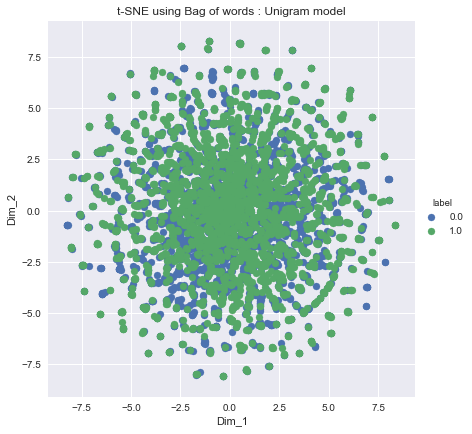

In [38]:
# seaborn facetgrod scatter plot : https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
sns.FacetGrid(tsne_unigram_df, hue="label", size=6).map(plt.scatter,'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE using Bag of words : Unigram model')
plt.show()

Observation:
Since positive and negative reviews are overlapping we are not able to draw a hyperplane which can separate reviews

### [5.1.2] Applying t-SNE on Text BOW vectors - bi-gram

In [39]:
# n_components : Dimension of the embedded space = 2
# random_state : seed used by the random number generator = 0
# perplexity : number of nearest neighbors used by algorithm = 50
# n_jobs : number of jobs to be scheduled = 4
# n_iter :  number of iterations for the optimization = 5000
# learning_rate : default value = 200

tsne_bigram_model = TSNE(n_components=2, random_state=0, perplexity= 50, n_jobs=4, n_iter = 5000, learning_rate = 200)
tsne_bigram_data = tsne_bigram_model.fit_transform(unigram_bow)

print("Shape of t-SNE_reduced data = ", tsne_bigram_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_bigram_newdata = np.vstack((tsne_bigram_data.T, labels)).T
tsne_bigram_df = pd.DataFrame(data=tsne_bigram_newdata, columns=("Dim_1", "Dim_2", "label"))

Shape of t-SNE_reduced data =  (5000, 2)


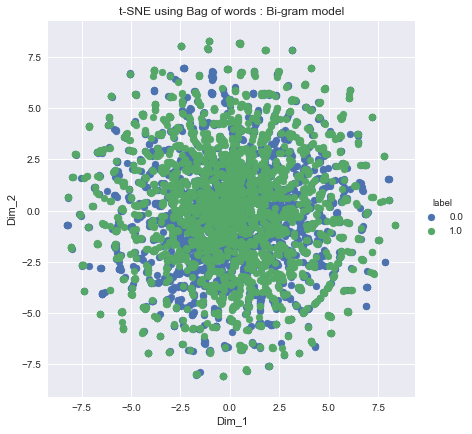

In [40]:
# seaborn facetgrod scatter plot : https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
sns.FacetGrid(tsne_bigram_df, hue="label", size=6).map(plt.scatter,'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE using Bag of words : Bi-gram model')
plt.show()

Observation:
Its showing same behavior as unigram model

## [5.2] Applying t-SNE on Text TFIDF vectors

In [41]:
# n_components : Dimension of the embedded space = 2
# random_state : seed used by the random number generator = 0
# perplexity : number of nearest neighbors used by algorithm = 50
# n_jobs : number of jobs to be scheduled = 4
# n_iter :  number of iterations for the optimization = 5000
# learning_rate : default value = 200

tsne_tfidf_model = TSNE(n_components=2, random_state=0, perplexity= 50, n_jobs=4, n_iter = 5000, learning_rate = 200)
tsne_tfidf_data = tsne_bigram_model.fit_transform(final_tf_idf)

print("Shape of t-SNE_reduced data = ", tsne_tfidf_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_tfidf_newdata = np.vstack((tsne_tfidf_data.T, labels)).T
tsne_tfidf_df = pd.DataFrame(data=tsne_tfidf_newdata, columns=("Dim_1", "Dim_2", "label"))

Shape of t-SNE_reduced data =  (5000, 2)


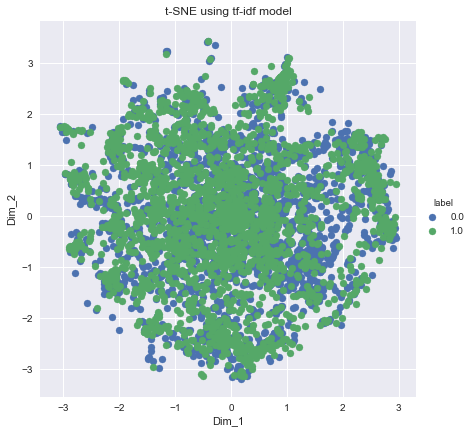

In [42]:
# seaborn facetgrod scatter plot : https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
sns.FacetGrid(tsne_tfidf_df, hue="label", size=6).map(plt.scatter,'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE using tf-idf model')
plt.show()

Observation:
Positive and negative reviews are massively overlapping each other

## [5.3] Applying t-SNE on Text Avg W2V vectors

In [43]:
# n_components : Dimension of the embedded space = 2
# random_state : seed used by the random number generator = 0
# perplexity : number of nearest neighbors used by algorithm = 50
# n_jobs : number of jobs to be scheduled = 4
# n_iter :  number of iterations for the optimization = 5000
# learning_rate : default value = 200

tsne_avg_w2v_model = TSNE(n_components=2, random_state=0, perplexity= 50, n_jobs=4, n_iter = 5000, learning_rate = 200)
tsne_avg_w2v_data = tsne_avg_w2v_model.fit_transform(avg_w2v)

print("Shape of t-SNE_reduced data = ", tsne_avg_w2v_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_avg_w2v_newdata = np.vstack((tsne_avg_w2v_data.T, labels)).T
tsne_avg_w2v_df = pd.DataFrame(data=tsne_avg_w2v_newdata, columns=("Dim_1", "Dim_2", "label"))

Shape of t-SNE_reduced data =  (5000, 2)


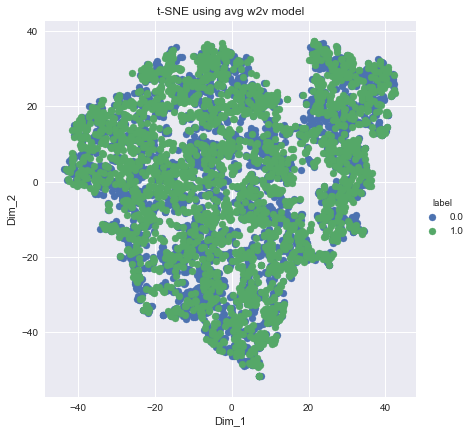

In [44]:
# seaborn facetgrod scatter plot : https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
sns.FacetGrid(tsne_avg_w2v_df, hue="label", size=6).map(plt.scatter,'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE using avg w2v model')
plt.show()

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

In [45]:
# n_components : Dimension of the embedded space = 2
# random_state : seed used by the random number generator = 0
# perplexity : number of nearest neighbors used by algorithm = 50
# n_jobs : number of jobs to be scheduled = 4
# n_iter :  number of iterations for the optimization = 5000
# learning_rate : default value = 200

tsne_avg_tfidf_w2v_model = TSNE(n_components=2, random_state=0, perplexity= 50, n_jobs=4, n_iter = 5000, learning_rate = 200)
tsne_avg_tfidf_w2v_data = tsne_avg_tfidf_w2v_model.fit_transform(avg_tfidf_w2v)

print("Shape of t-SNE_reduced data = ", tsne_avg_tfidf_w2v_data.shape)

# creating a new data frame which help us in ploting the result data
tsne_avg_tfidf_w2v_newdata = np.vstack((tsne_avg_tfidf_w2v_data.T, labels)).T
tsne_avg_tfidf_w2v_df = pd.DataFrame(data=tsne_avg_tfidf_w2v_newdata, columns=("Dim_1", "Dim_2", "label"))

Shape of t-SNE_reduced data =  (5000, 2)


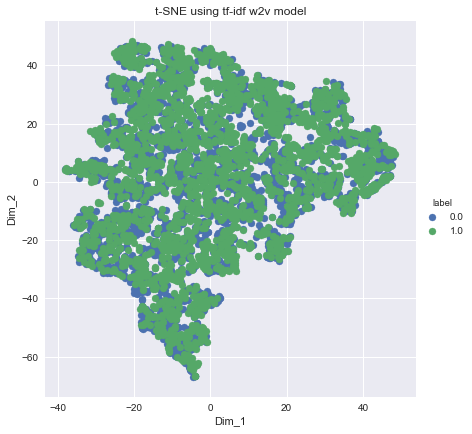

In [46]:
# seaborn facetgrod scatter plot : https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
sns.FacetGrid(tsne_avg_tfidf_w2v_df, hue="label", size=6).map(plt.scatter,'Dim_1', 'Dim_2').add_legend()
plt.title('t-SNE using tf-idf w2v model')
plt.show()

Plots for avg w2v and tf-df w2v also shows the same behavior as bow so we can not separate these reviews using hyperplane in 2D 

# [6] Conclusions

After plotting t-SNE plots for BoW, tf-idf, avg w2v and tf-idf w2v we can say that none of the model is able to separate reviews in 2 dimension.